In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import PIL
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
from tqdm import tqdm
import itertools
#from keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Add, Conv2D, MaxPooling2D,GlobalAveragePooling2D,ZeroPadding2D,Input, AveragePooling2D
from keras.models import Sequential
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
import pandas as pd
from tensorflow.keras import regularizers


from numpy.random import seed
#from tensorflow import set_random_seed
seed_value=42
seed(42)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
import random 
random.seed(seed_value)
np.random.seed(seed_value)
print(seed_value)

42


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/chest_xray/',    
        class_mode='categorical')


Found 11982 images belonging to 4 classes.


In [ ]:
def load_data():
    
    class_names = ['NORMAL', 'PNEUMONIA']
    class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
    
    print(format(class_names_label))
    
    nb_classes = len(class_names)

    
    
    paths = [r'/content/drive/MyDrive/chest_xray/train/', r'/content/drive/MyDrive/chest_xray/test/']
    
    output = []
    
    
    for dataset in paths:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
       
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                img_path = os.path.join(os.path.join(dataset, folder), file)
                image = cv2.imread(img_path)  
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert to gray scale 
                image = cv2.resize(image, (100,100)) 
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))
        print(output)

    return output


In [ ]:
#from keras.backend import batch_normalization
def create_model():    
    #import regularizers
    model = Sequential()
    #model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(l=0.00025), input_shape=(100, 100, 3)))
    #model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    #model.add(MaxPooling2D((2, 2)))
    #model.add(Dropout(0.5, seed=seed_value))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=regularizers.l2(l=0.00010), input_shape=(100, 100, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5, seed=seed_value))
    #model.add(BatchNormalization())
    #model.add(layers.Dropout(0.2,seed=seed_value))

    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform',  padding='same', kernel_regularizer=regularizers.l2(l=0.00010),))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',  kernel_regularizer=regularizers.l2(l=0.00010),))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5, seed=seed_value))
    #model.add(BatchNormalization())
    
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.50))

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(l=0.00040),))
    model.add(Dropout(0.5, seed=seed_value))
    #model.add(Dense(256, activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l1'))
    #model.add(Dropout(0.4, seed=seed_value))
    model.add(Dense(2, activation='softmax'))

    opt = keras.optimizers.Adam(learning_rate=0.00010)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print (model.summary())
    
    return model

In [ ]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else: 
        print("Confusion matrix, without Normalization")
    print(cm)
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                 horizontalalignment='center',
                 color="white" if cm[i,j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

In [ ]:
def train_model():
        (train_data, train_labels), (test_data, test_labels) = load_data()
        train_data, train_labels = shuffle(train_data, train_labels, random_state=seed_value)
    
        new_train = train_labels.shape[0]
        new_test = test_labels.shape[0]
    

        print ("Number of training examples: {}".format(new_train))
        print ("Number of testing examples: {}".format(new_test))
        print ("Each image is of size: {}".format((100,100)))
        

        
        train = train_data / 255.0 
        test = test_data / 255.0
        from sklearn.model_selection import train_test_split

    # Split the data
        train_img, valid_img, train_label, valid_label = train_test_split(train, train_labels, test_size=0.3, shuffle= True, random_state=seed_value)
        history = model.fit(train_img, train_label, batch_size=128, epochs=35, validation_data=(valid_img, valid_label))
        plt.subplot(121)
        plt.plot(history.history['accuracy'], label = "train accuracy")
        plt.plot(history.history['val_accuracy'], label = "val accuracy")
        plt.title("train_acc vs val_acc")
        plt.ylabel("accuracy")
        plt.xlabel("epochs")
        plt.legend()
        plt.show()

        #Plot loss function
        plt.subplot(122)
        plt.plot(history.history['loss'], label = "train loss")
        plt.plot(history.history['val_loss'], label = "val loss")
        plt.title("train_loss vs val_loss")
        plt.ylabel("loss")
        plt.xlabel("epochs")

        plt.legend()
        plt.show()
        test_loss = model.evaluate(test, test_labels)
        #report2 = metrics.classification_report(true_classes, predicted_classes_x, target_names=class_labels)
        #print(report2)
    
        predictions = model.predict(x=test, verbose=0)
        cm=confusion_matrix(y_true=test_labels, y_pred=np.argmax(predictions, axis=-1))
        cm_plot_labels = ['Normal', 'Pneumonia']
        plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
        print(classification_report(test_labels, np.argmax(predictions, axis=-1)))
        return model 

In [ ]:
root = '/content/drive/MyDrive/chest_xray/'
for item in os.listdir(root):
  #print('i')
  if not item.startswith('.') or os.path.isfile(os.path.join(root, item)):
    print(item)

train
test
__MACOSX
val


In [ ]:
count = len([name for name in os.listdir(root) if name.startswith(".")])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 conv2d_17 (Conv2D)          (None, 100, 100, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 50, 50, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 conv2d_19 (Conv2D)          (None, 50, 50, 128)       147584    
                                                      

100%|██████████| 3875/3875 [00:49<00:00, 78.01it/s]


[(array([[[[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        ...,

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
     

100%|██████████| 390/390 [00:04<00:00, 85.54it/s]


[(array([[[[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        ...,

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
     

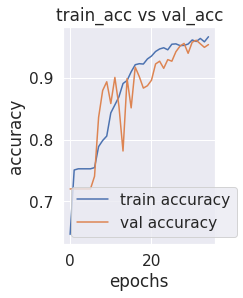

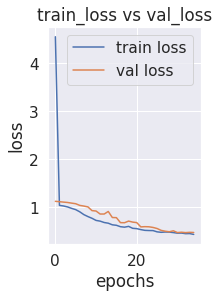

20/20 [==============================] - 1s 41ms/step - loss: 0.8234 - accuracy: 0.8093
Confusion matrix, without Normalization
[[129 105]
 [ 14 376]]
              precision    recall  f1-score   support

           0       0.90      0.55      0.68       234
           1       0.78      0.96      0.86       390

    accuracy                           0.81       624
   macro avg       0.84      0.76      0.77       624
weighted avg       0.83      0.81      0.80       624



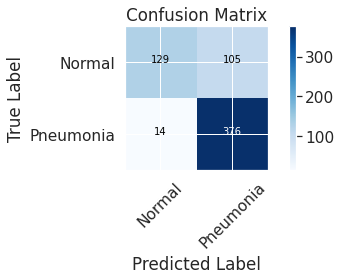

In [ ]:
model = create_model()
train_model()

With a LR of 0.00010; Accuracy is 0.85
with a LR of 0.00050; Accuracy is 0.76
with a LR of 0.0001; Accuracy is 